# **Preprocessing**

In [ ]:
from osgeo import gdal
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the path to the main folder containing class folders in Google Drive
folders_path = '/content/drive/MyDrive/Data/'

# List the class folders within the main folder
classes = os.listdir(folders_path)

# Create an empty dictionary to store class names and their corresponding numerical labels
dict_class = {}

# Iterate through the classes and assign a numerical label to each class
for i in range(len(classes)):
    # The numerical label is assigned as i+1 to start from 1
    dict_class.update({classes[i]: i + 1})

# Display the resulting dictionary
dict_class

{'PermanentCrop': 1,
 'River': 2,
 'Highway': 3,
 'Residential': 4,
 'SeaLake': 5,
 'Pasture': 6,
 'HerbaceousVegetation': 7,
 'AnnualCrop': 8,
 'Industrial': 9,
 'Forest': 10}

In [ ]:
# Define the total number of classes in your dataset
num_classes = 10

# Specify the number of patches
patch_numbers = 1000

# Define the size of each image patch (assuming it's a square)
patch_size = 64

# Specify the number of spectral bands in your satellite imagery
bands = 13

# Create empty arrays to store your input images (X) and corresponding labels (Y)
X = np.zeros((patch_numbers, patch_size, patch_size, bands), dtype='float32')
Y = np.zeros((patch_numbers, num_classes), dtype='float32')

In [ ]:
# Initialize a counter to keep track of the total number of patches processed
Counter = 0
# Iterate through each class in your dataset
for cls in classes:
    # Get a list of images in the current class folder
    image_list = os.listdir(folders_path + cls)

    # Iterate through each image in the current class
    for img in image_list:
        # Read the image using GDAL (assuming it's a raster image)
        image = gdal.Open(folders_path + cls + '/' + img).ReadAsArray()

        # Create an empty array to store the reshaped image with the desired patch size and bands
        new_image = np.zeros((patch_size, patch_size, bands), dtype='float32')

        # Iterate through each band in the original image
        for b in range(bands):
            # Copy the band to the corresponding slice in the new image
            new_image[:, :, b] = image[b, :, :]

        # Store the reshaped image in the X array
        X[Counter, :, :, :] = new_image

        # Determine the column (class label) for the current image and update the Y array
        column = dict_class[cls]
        Y[Counter, column - 1] = 1

        # Increment the counter
        Counter = Counter + 1

In [ ]:
# Print the shapes of the X and Y arrays for verification
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (1000, 64, 64, 13)
Y shape:  (1000, 10)


In [ ]:
# Create an array of indices ranging from 0 to the total number of patches
indexes = np.arange(X.shape[0])

# Shuffle the indices randomly to ensure randomness in train/validation split
np.random.shuffle(indexes)

# Determine the index for the split between training and validation sets (90%/10%)
train_index = indexes[: int(0.9 * X.shape[0])]
val_index = indexes[int(0.9 * X.shape[0]):]

# Use the indices to extract the corresponding patches for training and validation
x_train = X[train_index]
x_val = X[val_index]
y_train = Y[train_index]
y_val = Y[val_index]

# Print the shapes of the training and validation sets for verification
print('X Train shape: ', x_train.shape)
print('Y Train shape: ', y_train.shape)
print('X Validation shape: ', x_val.shape)
print('Y Validation shape: ', y_val.shape)

X Train shape:  (900, 64, 64, 13)
Y Train shape:  (900, 10)
X Validation shape:  (100, 64, 64, 13)
Y Validation shape:  (100, 10)


# **Deep Learning Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
def cnn_model(input_shape, num_classes=10):
    # Define the input layer with the specified shape
    inputs = layers.Input(shape=input_shape)

    # Convolutional and pooling layers to capture hierarchical features
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten the output for feeding into dense layers
    flat = layers.Flatten()(pool3)

    # Dense layers for classification with ReLU activation
    dense1 = layers.Dense(128, activation='relu')(flat)
    dense2 = layers.Dense(256, activation='relu')(dense1)

    # Output layer with softmax activation for multi-class classification
    dense3 = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create the model with the defined inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=dense3)

    return model

In [ ]:
# Define the input shape based on the shape of the training data (excluding the batch size)
input_shape = x_train.shape[1:]

# Create an instance of the CNN model using the defined input shape and specifying the number of classes
model = cnn_model(input_shape, num_classes=10)

# Display a summary of the model architecture, including the layers, parameters, and output shapes
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 13)]      0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856 

In [ ]:
# Compile the model with specified configuration for training
model.compile(
    # Use the Adam optimizer with a learning rate of 0.00001
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),

    # Use Binary Crossentropy as the loss function for binary classification
    loss=tf.keras.losses.BinaryCrossentropy(),

    # Track and display accuracy as a metric during training
    metrics=['accuracy']
)

In [ ]:
# Train the model on the training data
history = model.fit(
    # Input features (training data)
    x=x_train,

    # Target labels (training labels)
    y=y_train,

    # Validation data for monitoring model performance on a separate dataset
    validation_data=(x_val, y_val),

    # Number of epochs for training
    epochs=20
)

Epoch 1/20
29/29 [==============================] - 12s 29ms/step - loss: 66.8067 - accuracy: 0.1089 - val_loss: 17.4883 - val_accuracy: 0.1000
Epoch 2/20
29/29 [==============================] - 0s 12ms/step - loss: 13.3114 - accuracy: 0.1244 - val_loss: 9.0374 - val_accuracy: 0.1500
Epoch 3/20
29/29 [==============================] - 0s 13ms/step - loss: 7.6538 - accuracy: 0.1989 - val_loss: 6.3364 - val_accuracy: 0.1900
Epoch 4/20
29/29 [==============================] - 0s 13ms/step - loss: 5.9179 - accuracy: 0.3100 - val_loss: 5.3618 - val_accuracy: 0.3300
Epoch 5/20
29/29 [==============================] - 0s 11ms/step - loss: 5.0031 - accuracy: 0.3444 - val_loss: 4.7600 - val_accuracy: 0.3300
Epoch 6/20
29/29 [==============================] - 0s 11ms/step - loss: 4.3507 - accuracy: 0.3556 - val_loss: 4.6937 - val_accuracy: 0.3300
Epoch 7/20
29/29 [==============================] - 0s 11ms/step - loss: 4.0587 - accuracy: 0.3878 - val_loss: 3.9068 - val_accuracy: 0.3800
Epoch 8/2

**Model Assesment**

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score,confusion_matrix

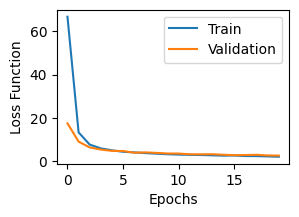

In [ ]:
# Set the figure size and dpi for the plot
plt.figure(figsize=(3, 2), dpi=100)

# Plot the training loss over epochs
plt.plot(np.array(history.history['loss']), label='Training Loss')

# Plot the validation loss over epochs
plt.plot(np.array(history.history['val_loss']), label='Validation Loss')

# Set labels for the axes
plt.ylabel('Loss Function')
plt.xlabel('Epochs')

# Add a legend to identify the lines in the plot
plt.legend(['Train', 'Validation'], loc='best')

# Display the plot
plt.show()

In [ ]:
# Evaluate the model on the validation data
evaluation_results = model.evaluate(x_val, y_val)

# Print or use the evaluation results as needed
print("Evaluation Results:", evaluation_results)


4/4 [==============================] - 0s 6ms/step - loss: 2.5772 - accuracy: 0.4900
Evaluation Results: [2.5772364139556885, 0.49000000953674316]


In [ ]:
# Make predictions using the trained model on the validation data
y_pred = model.predict(x_val)

# Display the shape of the predicted values
print("Shape of Predicted Values:", y_pred.shape)


4/4 [==============================] - 0s 5ms/step
Shape of Predicted Values: (100, 10)


In [ ]:
# Get the indices of the maximum values along axis 1 for predicted values
prediction = np.argmax(y_pred, axis=1)

# Get the indices of the maximum values along axis 1 for actual values (ground truth)
actual = np.argmax(y_val, axis=1)

In [ ]:
# Calculating F1 Score using the macro average method
f1 = f1_score(actual, prediction, average='macro')

# Calculating accuracy score
accuracy = accuracy_score(actual, prediction)

# Calculating precision using the macro average method
precision = precision_score(actual, prediction, average='macro')

# Calculating recall using the macro average method
recall = recall_score(actual, prediction, average='macro')

# Printing the computed metrics
print('F1 Score:', f1)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)


F1 Score: 0.43666591966834256
Accuracy: 0.47
Precision: 0.4483649683649684
Recall: 0.44247835497835497


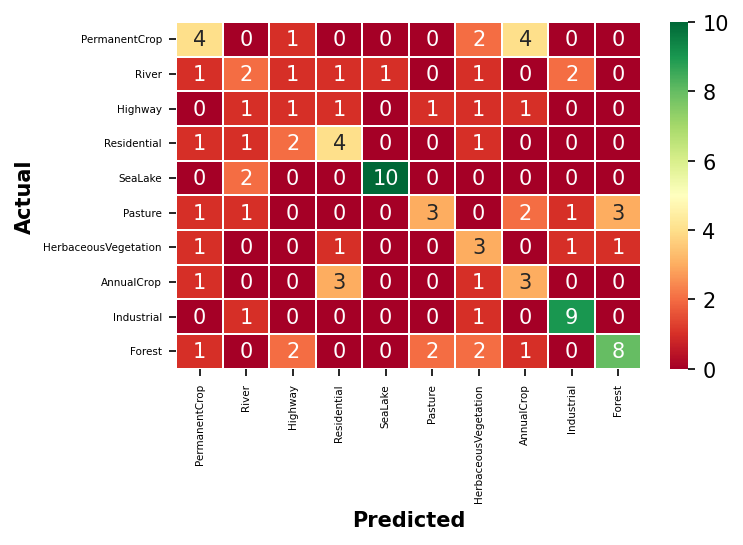

In [ ]:
# Creating a confusion matrix using actual and predicted values
cmat = confusion_matrix(actual, prediction)

# Assuming 'classes' is a variable containing the class labels
u = classes  # Class labels for y-axis
v = classes  # Class labels for x-axis

# Setting up the figure size and resolution for the heatmap
plt.figure(figsize=(5, 3), dpi=150)

# Creating a heatmap using seaborn with annotations, color map, and tick labels
b = sns.heatmap(cmat, annot=True, cmap='RdYlGn', linewidths=.2, yticklabels=u, xticklabels=v)

# Setting tick label sizes
b.set_yticklabels(u, size=5)
b.set_xticklabels(v, size=5)

# Adding labels for y-axis and x-axis
plt.ylabel('Actual', fontsize=10, fontweight='bold')
plt.xlabel('Predicted', fontsize=10, fontweight='bold')

# Displaying the heatmap
plt.show()